## **Sentiment Analysis - Yelp review** 

In [1]:
import pandas as pd
import os
import numpy as np
import json

import plotly.express as px

# word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# nlp 
import string
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# text data processing
import nltk
#nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# model deployment
from flask import Flask
import pickle

In [2]:
def load_data(name):

    data_path = r'data/yelp dataset/yelp_academic_dataset_{}.json'.format(name)
    load = pd.read_json(data_path, lines=True)
    return load

In [3]:
review_df = load_data('review')

In [4]:
review_df['date'] = pd.to_datetime(review_df['date'])
review_df['year'] = review_df['date'].dt.year
review_df['month'] = review_df['date'].dt.month

In [5]:
business_df = load_data('business')

In [6]:
business_cate = business_df[['business_id', 'categories', 'name', 'is_open', 'state']]
review_bus = pd.merge(review_df, business_cate, on=['business_id'])
review_bus = review_bus.dropna()

In [13]:
res_lis = 'Restaurants|Bars|Desserts|Coffee & Tea|Donuts|Food'
rest_review = review_bus.loc[review_bus['categories'].str.contains(res_lis)] # selecting restaurants
rest_review = rest_review.loc[rest_review['categories'].str.contains('Grocery') == False] # dropping grocery

In [ ]:
# star distribution for restaurant
star_dis = rest_review['stars'].value_counts().reset_index(name='count_rating').sort_values(by='index')
fig = px.bar(star_dis, x='index', y='count_rating',
            title='Star distribution' )

fig.update_layout(autosize=False,
    width=700,
    height=500)

In [ ]:
# review amount trend
num_review_year = rest_review['year'].value_counts().reset_index(name='number of review').sort_values(by='index')
fig = px.line(num_review_year, x='index', y='number of review', title='Number of review trend')

fig.update_layout(autosize=False,
    width=700,
    height=500)

In [ ]:
num_review_month = rest_review['month'].value_counts().reset_index(name='number of review').sort_values(by='index')
fig = px.line(num_review_month, x='index', y='number of review', title='Number of review trend')
fig.update_layout(autosize=False,
    width=700,
    height=500)

In [ ]:
rest_gp = rest_review.groupby('name')
start_review = rest_gp['year'].min().reset_index()
count_rest_year = start_review.groupby('year').count().reset_index()
count_rest_year = count_rest_year[count_rest_year['year'] != 2022]
count_rest_year = count_rest_year.rename({'name':'count_rest'}, axis=1)


In [ ]:
fig = px.line(count_rest_year, x='year', y='count_rest')
fig.show()

In [ ]:
# save visulization dataset to csv
# star_dis.to_csv(r'./visuization/star_distri.csv')
# num_review_year.to_csv(r'./visuization/review_trend_year.csv')
# num_review_month.to_csv(r'./visuization/review_trend_month.csv')
# count_rest_year.to_csv(r'./visuization/count_rest_peryear.csv')

In [ ]:
# data preparation
rest_gp = rest_review.groupby(by=['name', 'year'])
rest_rating = rest_gp['stars'].mean().reset_index()

def rating_year_trend(restaurant_name):

    temp = rest_rating.loc[rest_rating['name'] == restaurant_name]

    fig = px.line(temp, x='year', y='stars', title='Rating trend for {}'.format(restaurant_name))
    
    fig.update_layout(autosize=False,
    width=700,
    height=500)
    
    return fig

#### Sentiment analysis

In [14]:
# data preparation
review_sentiment = rest_review[['text', 'stars', 'useful']]
review_sentiment = review_sentiment.loc[review_sentiment['useful']>0].reset_index()
review_sentiment = review_sentiment[['text', 'stars']]

In [15]:
# convert stars to 2-scale
review_sentiment['sentiment'] = review_sentiment['stars'].replace({1:0, 2:0, 3:0, 4:1, 5:1})
review_sentiment = review_sentiment[['text', 'sentiment']]

In [ ]:
# starbucks_review['sentiment'] = starbucks_review['stars'].replace({1:0, 2:0, 3:0, 4:1, 5:1})
# starbucks_review = starbucks_review.drop('stars', axis=1)

In [16]:
# remove new line
def remove_newline(text):
    return ''.join(text.splitlines())

In [17]:
# replace contraction
def replace_contractions(text):
    text = re.sub(r"won't", "will not", str(text))
    text = re.sub(r"would't", "would not",str(text))
    text = re.sub(r"could't", "could not",str(text))
    text = re.sub(r"\'d",  " would",str(text))
    text = re.sub(r"can't", "can not",str(text))
    text = re.sub(r"n\'t", " not", str(text))
    text = re.sub(r"\'re", " are", str(text))
    text = re.sub(r"\'s", " is", str(text))
    text = re.sub(r"\'ll", " will", str(text))
    text = re.sub(r"\'t", " not", str(text))
    text = re.sub(r"\'count=ve", " have", str(text))
    text = re.sub(r"\'m", " am", str(text))
    return str(text)

In [18]:
# remove punctuation
def remove_punc(text):
    for punc in string.punctuation:
        text = text.replace(punc, '')
    return text

In [19]:
# remove all non-charater
def remove_non_char(text):
    text = re.sub('[0-9]+', '', str(text))
    return text

In [20]:
# lemmatization

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


In [21]:
def text_data_preprossing(text):
    
    # remove new line
    text = text.apply(remove_newline)

    # replace contraction
    text = text.apply(replace_contractions)

    # remove punctuation
    text = text.apply(remove_punc)

    # remove extra space 
    text = text.apply(lambda x: re.sub(' +', ' ', str(x)))

    # remove stop words
    stop = stopwords.words("english")
    text = text.apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

    # remove all non_char
    text = text.apply(remove_non_char)

    #covert to lowercase
    text = text.str.lower()

    # lemmatization
    text = text.apply(lemmatize_text)

    return text

In [21]:
# TfidVectorizer
tf = TfidfVectorizer(min_df=0.01, lowercase=False)

X = review_sentiment['text']
y = review_sentiment['sentiment']

Tf_transformer = tf.fit(X)
print('X fit completed')

X fit completed


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

X_train_transform = Tf_transformer.transform(X_train)
print('X_train transform completed')
X_test_transform = Tf_transformer.transform(X_test)
print('X_test transform completed')

X_train transform completed
X_test transform completed


In [25]:
# Logistic model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_transform, y_train)

LogisticRegression(max_iter=1000)

In [32]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(tf, log_model)

In [45]:
# with open(r'pipeline.pkl', 'wb') as file:
#     pickle.dump(pipeline, file)

In [46]:
pred_test = pipeline.predict(X_test)

In [38]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83    225598
           1       0.90      0.93      0.91    419333

    accuracy                           0.89    644931
   macro avg       0.88      0.87      0.87    644931
weighted avg       0.88      0.89      0.88    644931



In [25]:
def wordcloud_star(star = None, custom_stopword = None, restaurant = None):
    """
    Generating word cloud based on rating and restaurant
    
    Parameters:
    star (int): specific rating 
    cutome_stopword (str): additional stopword can be added to stop word list
    restaurant (str): specific restaurant name

    Returns:
    A word cloud image for specific rating and restaurant
    
    """
    

    # data preparation
    if restaurant:
        review = rest_review.loc[rest_review['name'] == restaurant]
        review = review.loc[review['stars'] == star]
        review = review.loc[review['useful']>1]
        review = review[['text']]
    
    else:
        review = rest_review.loc[rest_review['stars']==star]
        review = review.loc[review['useful']>1]
        review = review[['text']]
        

    
    # text data processing
    if custom_stopword:
        stop_word = text.ENGLISH_STOP_WORDS.union(custom_stopword)
    else:
        stop_word = text.ENGLISH_STOP_WORDS

    review['text'] = text_data_preprossing(review['text'])

    # apply TfidVectorizer to get frequency
    tf = TfidfVectorizer(max_features = 500, stop_words = stop_word)
    review_tfid = tf.fit_transform(review['text'])
    review_feature = tf.get_feature_names_out()
    review_feature_df = pd.DataFrame(data=review_tfid.toarray(), columns=review_feature).head()

    # word cloud data 
    review_wc = pd.DataFrame(data=review_feature_df.T.sum(axis=1)).reset_index()
    review_wc = review_wc.sort_values(by = 0, ascending=False)
    review_wc = review_wc.loc[(review_wc[0]!=0)]
    review_wc = dict(zip(review_wc['index'].tolist(), review_wc[0].tolist()))

    # generate word cloud
    Wordcloud_re = WordCloud(background_color='white').generate_from_frequencies(review_wc)

    plt.imshow(Wordcloud_re, interpolation='bilinear')
    
    if restaurant:
        plt.title('Word Cloud for {} {} star review'.format(restaurant, star))
    else:
        plt.title('Word Cloud for {} star review'.format(star))
    
    plt.axis('off')
    plt.show()

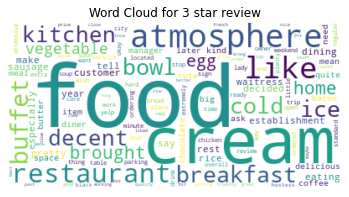

In [27]:
wordcloud_star(star=3)

In [177]:
def n_grams_top10(n, restaurant, state, pos_or_neg):

    rest_review['sentiment'] = rest_review['stars'].replace({1:0, 2:0, 3:0, 4:1, 5:1})

    reivew = rest_review.loc[rest_review['name'] == restaurant]
    reivew = reivew.loc[reivew['sentiment'] == pos_or_neg]
    reivew = reivew.loc[reivew['state'] == state]

    ngram = CountVectorizer(ngram_range=(n,n), analyzer='word', stop_words='english')
    ngram_text = ngram.fit_transform(reivew['text'])
    frequencies = sum(ngram_text).toarray()[0]
    return pd.DataFrame(frequencies, index=ngram.get_feature_names_out(), columns=['frequency']).sort_values('frequency', ascending=False)[:10]

In [209]:
n_grams_top10(3, "McDonald's", 'PA', 0)

,frequency
fast food restaurant,36
ice cream machine,33
worst mcdonald ve,25
fast food place,22
poor customer service,20
waited 10 minutes,19
quarter pounder cheese,18
horrible customer service,17
crispy chicken sandwich,17
double quarter pounder,16
